# Exercise Sheet 03: Item response theory and variational autoencoders

**Introduction to Data Mining WS23/24**  
**Bielefeld University**  
**Alina Deriyeva, Benjamin Paaßen**  
**Exercise Sheet Publication Date: 2023-11-20**  
**Exercise Sheet Submission Deadline: 2023-12-01, noon (i.e. 12:00), via **moodle** (please do not use e-mail submissions anymore).

**NOTE** The use of language models/AI tools is permitted IF you notify us of the use (just indicate it in the respective task) and are still able to understand and present your results. We also appreciate it if you link to a chatlog of the interaction with the language model/AI tool so that we can understand better how students tend to use these tools.

**Fynn Jonathan Rühlemann, Dennis Schielke, Toby Oderinlo**

## Preamble: Data set

The file `sheet03_data.csv` contains fictional data of a class of students completing a set of tasks. Each row indicates a student, each column indicates a task. Each task is only graded as 'passed' (1) or 'failed' (0).

The following code loads this raw data and prints it.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

X = np.loadtxt('sheet03_data.csv', skiprows = 1, delimiter = '\t', dtype=int)
N, m = X.shape
print(X)

[[1 1 0 ... 0 1 0]
 [1 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 1 ... 1 1 1]
 [1 0 0 ... 0 0 0]]


### Task 03.01

Before we apply any advanced data mining, let us compute some basic statistics to get a sense of the data.

Provide a bar plot with the task index on the x axis and the pass rate on the y axis. Don't forget to label your axes.

Provide a second bar plot with the student index on the x axis and the pass rate on the y axis. Don't forget to label your axes.

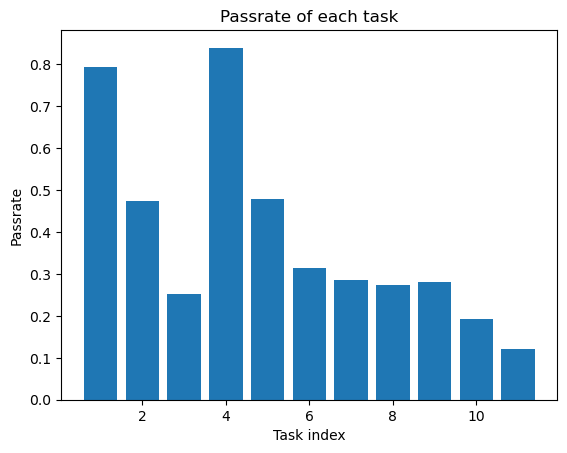

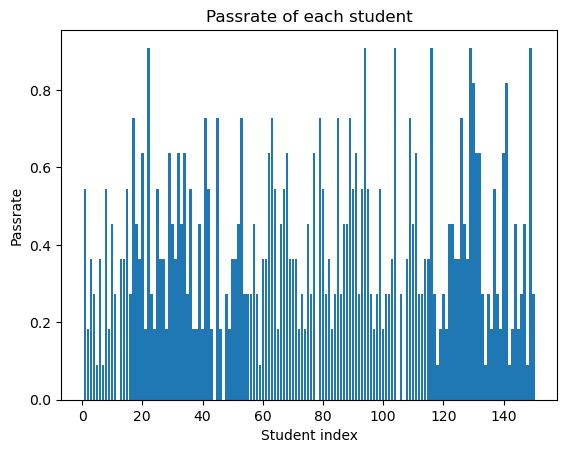

In [14]:
# Calculate the passrate for each task
passrate = []
task = [x for x in range(1, len(X[0])+1)]
for i in range(len(X[0])):
    passrate.append(round(sum(X[:,i]) / len(X[:,i]),4))

# Plot the passrate
plt.bar(task, height=passrate)
plt.title("Passrate of each task")
plt.xlabel("Task index")
plt.ylabel("Passrate")
plt.show()

# Calculate the passrate for each student
passrate2 = []
student = [x for x in range(1, len(X)+1)]
for i in X:
    passrate2.append(round(sum(i) / len(i), 4))

# Plot the passrate
plt.bar(student, height=passrate2)
plt.title("Passrate of each student")
plt.xlabel("Student index")
plt.ylabel("Passrate")
plt.show()

## Item Response Theory

Now, we want to fit item response theory models to our data. We will start with a 1-parameter model and then continue with a 2-parameter model.

For the former, we will use the [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) interface from scikit-learn. For the latter, we will use the [girth](https://github.com/eribean/girth) software package.

### Task 03.02

Right now, our data is in the form of an $N \times m$ matrix, where $N$ is the number of students and $m$ is the number of tasks. To plug this data into logistic regression, we need to convert it to a different format.

1. Prepare a $(N \cdot m) \times (N + m)$ matrix `Xlogreg` where each row represents a student-task combination. All entries are zero except for the entries `Xlogreg[i*m+j, i] = 1`, `Xlogreg[i*m+j, N+j] = 1` for all $i \in \{0, \ldots, N-1\}$ and all $j \in \{0, \ldots, m\}$. This is the feature matrix for our logistic regression.
2. Prepare a vector `ylogreg` with $N \cdot m$ entries where each entry represents a student-task combination and `ylogreg[i*m+j] = X[i, j]` for all $i \in \{0, \ldots, N-1\}$ and all $j \in \{0, \ldots, m\}$.

In [19]:
# Define Xlogreg
Xlogreg = np.zeros((N*m, N+m))

# Set the values to 1 that are needed
for i in range(N):
    for j in range(m):
        Xlogreg[i*m+j, i] = 1
        Xlogreg[i*m+j, N+j] = 1

# Define ylogreg. We can use flatten to archieve the wanted result
ylogreg = X.flatten()

### Task 03.03

Use the new format of the data to train an [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model with `penalty = 'l2'`, `C = 1.0`, and `fit_intercept = False`.

Report the accuracy of the model by printing the output of the `score` function of the model.

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Split dataset

X_train, X_test, y_train, y_test = train_test_split(Xlogreg, ylogreg, test_size=0.25, random_state=69)

# Create model and fit it

log = LogisticRegression(penalty="l2", C=1.0, fit_intercept=False)
log.fit(X_train, y_train)

# Get acc score
acc = log.score(X_test, y_test)

print(f"The accuracy of the model is {acc:.4f}")

The accuracy of the model is 0.7579


### Task 03.04

The learned parameters of the model are stored in the `coef_` attribute. The first $N$ parameters represent the estimated student abilities, the last $m$ parameters represent the negative (!) estimated task difficulties.

Extract abilities and task difficulties.

Provide a scatter plot with estimated task difficulties on the x axis and pass rates on the y axis. Don't forget to label your axes.

Provide a scatter plot with estimated student abilities on the x axis and pass rates on the y axis. Don't forget to label your axes.

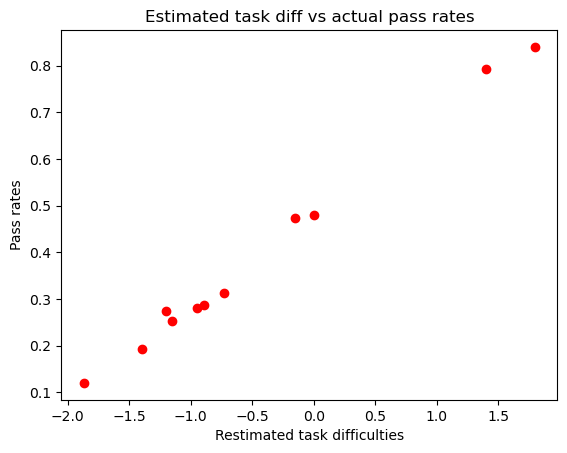

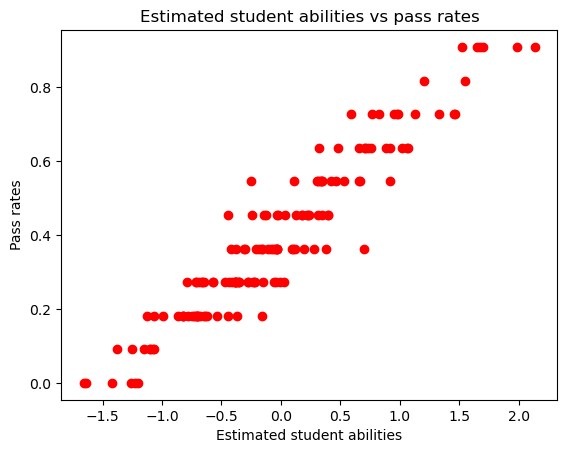

In [39]:
# Get the learned parameters
coe = log.coef_

# Get estimated values
stud = coe[0][:N]
task = coe[0][N:]

# First scatter Plot

plt.scatter(task, passrate, color="red")
plt.title("Estimated task diff vs actual pass rates")
plt.xlabel("Restimated task difficulties")
plt.ylabel("Pass rates")
plt.show()

# Second scatter plot
plt.scatter(stud, passrate2, color="red")
plt.title("Estimated student abilities vs pass rates")
plt.xlabel("Estimated student abilities")
plt.ylabel("Pass rates")
plt.show()

### Task 03.05

Plot the item characteristic curve for the second task (item index 1) according to your IRT model. To do so, sample 61 abilities via the `np.linspace` function in the range $[-3, +3]$ and plot the value of the function

\begin{equation*}
p(x = 1|\theta, b_2) = \frac{1}{1 + \exp(-(\theta - b_2))}
\end{equation*}

where $b_2$ is the difficulty of the second task and $\theta$ is the ability.

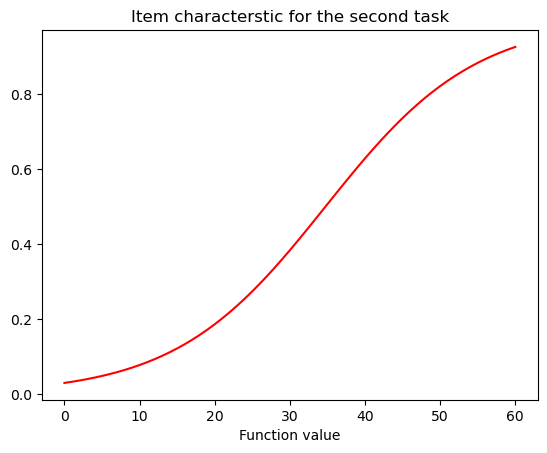

In [89]:
# Given function
def p(theta, b2):
    return 1 / (1+np.exp(-(theta-b2)))

# Samples
abilitys = np.linspace(-3, 3, 61)

# Task difficulty
b2 = sum(X[:,1]) / len(X[:,1])

# Calculated values
vals = p(abilitys, b2)

#Plot
plt.plot(vals, color="red")
plt.title("Item characterstic for the second task")
plt.xlabel("X value")
plt.xlabel("Function value")
plt.show()

### Task 03.06

To validate the item characteristic curve, provide a plot of the pass rate of students within a certain range of abilities. In particular, compute the pass rates for students with an ability between -2.5 and -1.5, between -1.5 and -0.5, between -0.5 and +0.5, beween +0.5 and +1.5, and between +1.5 and +2.5. Then, plot these values on the y axis versus x values -2, -1, 0, +1, +2.

Plot the item characteristic curve as well.

Compare the pass rate curve to the item characteristic curve. Are they similar? What is different?

In [67]:
# Define boundaries
boundaries = [(-2.5, -1.5), (-1.5, -0.5), (-0.5, 0.5), (0.5, 1.5), (1.5, 2.5)]

# Define x values for plot
x_values = [-2, -1, 0, 1, 2]

# Creates list of lists
values = []
for i in range(len(x_values)):
    values.append([])

newabil = np.linspace(-2.5, 2.5, len(X))

for i in newabil:
    for index, (l, u) in enumerate(boundaries):
        if i > l and i < u:
            values[index].append((x_values[index], i))


29


**ANSWER:**

### Task 03.07

Now, use the `twopl_mml` function from the [girth](https://github.com/eribean/girth) software package to fit a 2-parameter IRT model to the data. The output of the function is a two parameter IRT model given in form of a python dictionary. You can extract the estimated difficulties via `model['Difficulty']`, the abilities via `model['Ability']`, and the discriminations via `model['Discrimination']`.

**NOTE:** girth assumes that each row represents a task and each column a student. In our data format, this is flipped. So you need to transpose the data before feeding it into the `twopl_mml` function.

In [ ]:
# this command installs the girth software package
%pip install girth

In [ ]:
from girth import twopl_mml

# Transpose the data since girth needs the flipped format
trans = np.transpose(X)

# Create the model
model = twopl_mml(trans)

# Extract the values
diff = model["Difficulty"]
abil = model["Ability"]
disc = model["Discrimination"]

# Print the values

print("Estimated Difficulties:", diff)
print("Estimated Abilities:", abil)
print("Estimated Discriminations:", disc)


### Task 03.08

Let's try to compute the accuracy of the model. To do so, we need to get the predictions of the 2-parameter model and compare them to the actual passes/fails of the students.

The prediction of the model is given as

\begin{equation*}
\hat x_{i, j} =
\begin{cases}
1 & \text{if } b_j < \theta_i \\
0 & \text{otherwise}
\end{cases}
\end{equation*}

where $b_j$ is the estimated difficulty for task $j$ and $\theta_i$ is the estimated ability for student $i$.

Compute the matrix `Xhat` of predicted pass/fails and then compute the accuracy as `np.mean(Xhat == X)`. Print the accuracy.

In [78]:
# Create Matrix with zerso like the shape of X
Xhat = np.zeros_like(X)

# Fill in the values 
for i in range(N):
    for j in range(m):
        if diff[j] < abil[i]:
            Xhat[i,j] = 1

# Calculate the accuracy of the model with the given values
acc = np.mean(Xhat == X)
print(f"The accuracy of the model is: {acc:.4f}")


The accuracy of the model is: 0.8152


### Task 03.09

Provide a scatter plot with the estimated difficulties of the logistic regression model on the x axis and the difficulties of the 2-parameter model on the y axis. Which differences do you notice?

Provide a scatter plot with the estimated abilities of the logistic regression model on the x axis and the abilities of the 2-parameter model on the y axis. Which differences do you notice?

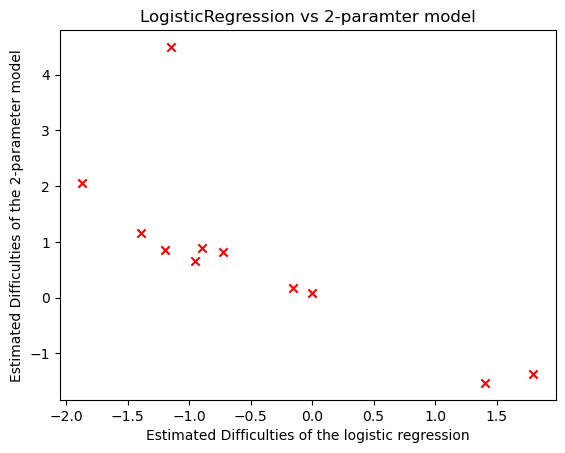

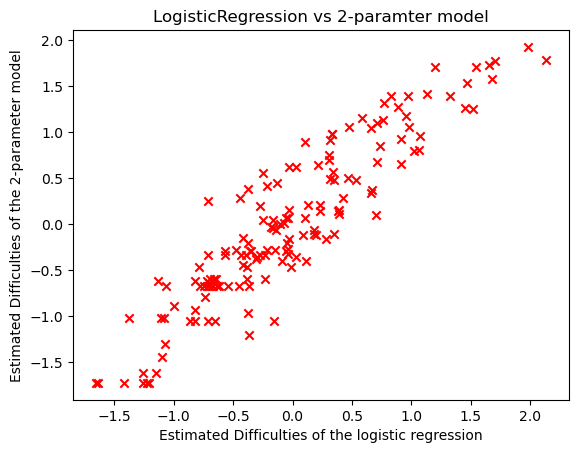

In [81]:
# Difficulty plot
plt.scatter(task, diff, marker="x", c="red")
plt.title("LogisticRegression vs 2-paramter model")
plt.xlabel("Estimated Difficulties of the logistic regression")
plt.ylabel("Estimated Difficulties of the 2-parameter model")
plt.show()

# Abilitiy plot
plt.scatter(stud, abil, marker="x", c="red")
plt.title("LogisticRegression vs 2-paramter model")
plt.xlabel("Estimated Difficulties of the logistic regression")
plt.ylabel("Estimated Difficulties of the 2-parameter model")
plt.show()

**ANSWER:** 

### Task 03.10

Plot the item characteristic curve of the 2-parameter model for the second task and compare it to the item characteristic curve for the logistic regression model of the second task. What differences do you notice?

Recall: For a 2-parameter model, the item characteristic curve is given as
\begin{equation*}
p(x = 1|\theta, b_2, a_2) = \frac{1}{1 + \exp\Big(-a_2 \cdot (\theta-b_2)\Big)}
\end{equation*}
where $a_2$ is the discrimination parameter for the second task.

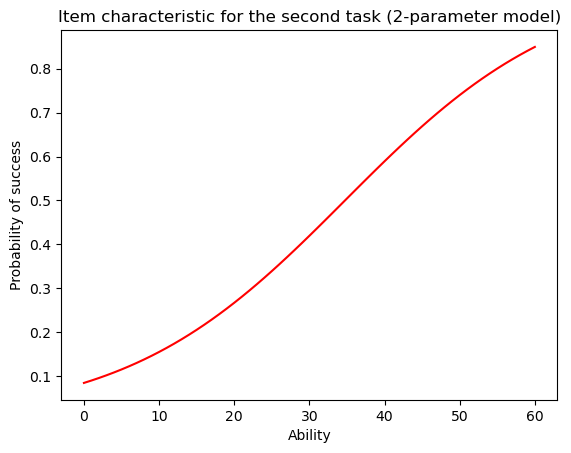

In [92]:
def p2(theta, b2, a2):
    return 1 / (1+np.exp(-a2*(theta-b2)))

abilitys = np.linspace(-3, 3, 61)
a2 = disc[1]

vals2Par = p2(abilitys, b2, a2)
#Plot
plt.plot(vals2Par, color="red")
plt.title("Item characteristic for the second task (2-parameter model)")
plt.xlabel("Ability")
plt.ylabel("Probability of success")
plt.show()


**ANSWER:** The biggest difference is the curvage of the curve. The curve of the characteristic of the Logistic Regression is stronger, where the second curve from the 2 parameter model goes more towards a line.

### Task 03.11

To validate the item characteristic curve, provide a plot of the pass rate of students within a certain range of abilities. In particular, compute the pass rates for students with an ability between -2.5 and -1.5, between -1.5 and -0.5, between -0.5 and +0.5, beween +0.5 and +1.5, and between +1.5 and +2.5. Then, plot these values on the y axis versus x values -2, -1, 0, +1, +2.

Plot the item characteristic curve as well.

Compare the pass rate curve to the item characteristic curve. Are they similar? What is different?

**ANSWER:** 

## Variational Autoencoder

Next, we will try to fit a variational autoencoder to the data. For that purpose, we will use the [pytorch](https://pytorch.org/) software package. The following line installs pytorch.

In [ ]:
%pip install torch

Pytorch takes care of adjusting the parameters of your model. However, you still need to specify the architecture as well as the loss function you want to optimize. The following cell provides a template for a proper pytorch model setup. In particular, this class implements a one-parameter IRT model.

In [ ]:
import torch

class IRTModel(torch.nn.Module):
    """The initialization method of a pytorch module. Here, we should set all hyperparameters
    of the model, such as the regularization strength.

    Parameters
    ----------
    C: float (default = 1000)
        The inverse of the L2 regularization strength.
    num_epochs: int (default = 1000)
        How many times we iterate over the data set during training.
    learning_rate: float (default = 1E-2)
        The learning rate of our optimizer during training.
    """
    def __init__(self, C = 1000, num_epochs = 1000, learning_rate = 1E-2):
        # We call the torch.nn.Module constructor
        super(IRTModel, self).__init__()
        # Then, we store all hyperparameters as attributes of the model
        self.C_ = C
        self.num_epochs_ = num_epochs
        self.learning_rate_ = learning_rate

    """Predicts responses based on the learned parameters.
    
    Parameters
    ----------
    X: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry X[i, j] is expected to be 0 if student i failed task j and to be 1
        if student i passed task j.

    Returns
    -------
    Z: torch.tensor
        A matrix where each row represents a student and each column represents a task.
        The entry Z[i, j] represents the logit probability of student i passing task j.
    
    """
    def predict_logits(self, X = None):
        # the logits correspond to the difference of abilities and difficulties.
        # The 'unsqueeze' method transforms the abilities vector from an N-entry
        # vector to an (N, 1)-matrix and the difficulties vector from an m-entry
        # vector to an (1, m)-matrix, such that the difference - thanks to the
        # magic of broadcasting - yields a (N, m) matrix.
        Z = self.abilities_.unsqueeze(1) - self.difficulties_.unsqueeze(0)
        return Z

    """Predicts responses based on the learned parameters.
    
    Parameters
    ----------
    X: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry X[i, j] is expected to be 0 if student i failed task j and to be 1
        if student i passed task j.

    Returns
    -------
    Xhat: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry Xhat[i, j] is 1 if the model predicts student i to pass task j and 0
        otherwise.
    
    """
    def predict(self, X = None):
        Z = self.predict_logits()
        Xhat = torch.zeros_like(Z)
        Xhat[Z > 0.] = 1.
        return Xhat.detach().numpy()

    """Fits this model to the given data matrix.

    Parameters
    ----------
    X: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry X[i, j] is expected to be 0 if student i failed task j and to be 1
        if student i passed task j.

    """
    def fit(self, X):
        # convert the input matrix to a pytorch tensor
        X = torch.tensor(X, dtype=torch.float)
        # initialize our model parameters based on passing rates, meaning:
        # students have higher initial ability if they get more tasks right and
        # items have higher initial difficulty if less students get them right.
        self.abilities_    = torch.nn.Parameter(torch.mean(X, 1).detach() - 0.5)
        self.difficulties_ = torch.nn.Parameter(0.5 - torch.mean(X, 0).detach())
        # initialize optimizer with the right learning rate and regularization strength
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate_, weight_decay=1./self.C_)
        # start training
        for epoch in range(self.num_epochs_):
            # re-set the current gradient to zero
            optimizer.zero_grad()
            # predict the logit passing probabilities for each student-item combination
            # with the current model
            Z = self.predict_logits()
            # compute the loss between predicted and desired answers using the crossentropy loss
            loss = torch.nn.functional.binary_cross_entropy_with_logits(Z, X)
            # report the loss every 100 steps
            if (epoch+1) % 100 == 0:
                print('epoch %d: loss %g' % (epoch+1, loss.item()))
            # compute the gradient
            loss.backward()
            # apply the optimizer
            optimizer.step()
        
        return self

And the following cell trains this model for our data.

In [ ]:
model_pytorch = IRTModel()
model_pytorch.fit(X)

plt.plot(abilities, model_pytorch.abilities_.detach().numpy(), 'o')
plt.xlabel('logreg IRT ability')
plt.ylabel('pytorch IRT ability')
plt.show()

plt.plot(difficulties, model_pytorch.difficulties_.detach().numpy(), 'o')
plt.xlabel('logreg IRT difficulty')
plt.ylabel('pytorch IRT difficulty')
plt.show()

### Task 03.12

Starting from the template given above, set up a `torch.nn.Module` class representing a (variational) autoencoder for our data. The encoder should translate the vector of pass/fail information for one student to a two-dimensional ability vector for this student. The decoder should translate the two-dimensional abilities back to logit-probabilities of passing each task. The loss function should be the crossentropy (just as in the IRT model above) plus a loss term for the variational autoencoder.

How you structure your architecture in detail is up to you. It is recommended to not go too wild, though, in order to keep training times manageable.

In [ ]:
import torch

class VAE_IRT_Model(torch.nn.Module):
    def __init__(self):
        # We call the torch.nn.Module constructor
        super(VAE_IRT_Model, self).__init__()

### Task 03.13

Fit your model to the data matrix `X`. After fitting the model, compute the accuracy of the model and print it.

### Task 03.14

Compute the latent representation of each student, using the trained model.
Provide two scatter plots (as part of the same plot), one for each latent dimension, with the pass rate of each student on the y axis and the latent representation values on the x axis.

Try to interpret these plots. Do you notice any patterns?

**ANSWER:** 